<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-датасета-и-первый-взгляд-на-него" data-toc-modified-id="Импорт-датасета-и-первый-взгляд-на-него-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт датасета и первый взгляд на него</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Dummy-модель" data-toc-modified-id="Dummy-модель-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dummy модель</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт датасета и первый взгляд на него

Подключим нужные библиотеки, прочитаем файлы и посмотрим на их значения, размеры и типы данных.

In [1]:
!pip install lightgbm
!pip install --upgrade scikit-learn

import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier

from sklearn.feature_selection import RFE

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re


from IPython.display import display
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.2 MB 128 kB/s eta 0:00:01    |█████▉                          | 4.2 MB 2.3 MB/s eta 0:00:09     |█████████▌                      | 6.9 MB 2.3 MB/s eta 0:00:08     |█████████████████▍              | 12.6 MB 2.3 MB/s eta 0:00:05     |████████████████████████        | 17.3 MB 2.3 MB/s eta 0:00:03


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
display(df)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
print('Число дубликатов:', df.duplicated().sum())

Число дубликатов: 0


Уберем мусор:

In [6]:
df['text'] = df['text'].str.lower().apply(lambda x: re.sub(r'[^a-z ]', ' ', x))

Посмотрим, насколько сбалансирован датасет.

In [7]:
df.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Получили, что нулевых ответов в 9 раз больше, чем единичных. Будем решать эту проблему взвешиванием классов.

### Лемматизация

In [8]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def clean_lemm(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])

In [9]:
df['lemm_text'] = df['text'].apply(clean_lemm)

In [10]:
df

,text,toxic,lemm_text
0,explanation why the edits made under my userna...,0,explanation why the edits make under my userna...
1,d aww he matches this background colour i m s...,0,d aww he match this background colour i m seem...
2,hey man i m really not trying to edit war it...,0,hey man i m really not try to edit war it s ju...
3,more i can t make any real suggestions on im...,0,more i can t make any real suggestion on impro...
4,you sir are my hero any chance you remember...,0,you sir be my hero any chance you remember wha...
...,...,...,...
159566,and for the second time of asking when ...,0,and for the second time of ask when your view ...
159567,you should be ashamed of yourself that is a ...,0,you should be ashamed of yourself that be a ho...
159568,spitzer umm theres no actual article for pr...,0,spitzer umm there no actual article for prosti...
159569,and it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


## Обучение

In [11]:
features = df['lemm_text']
target = df['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=12345, stratify=target)

In [12]:
print('Размер обучающих фич:', features_train.shape)
print('Размер тестовых фич:', features_test.shape)

Размер обучающих фич: (143613,)
Размер тестовых фич: (15958,)


In [13]:
stopwords = set(nltk_stopwords.words('english'))
corpus = features_train #.values.astype('U')
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)
print("Размер обучающих фич:", features_train.shape)
print("Размер тестовых фич:", features_test.shape)

Размер обучающих фич: (143613, 142400)
Размер тестовых фич: (15958, 142400)


In [14]:
f1_scorer = make_scorer(f1_score)

### Dummy модель

In [15]:
dummy = DummyClassifier(strategy="uniform", random_state=12345)

dummy.fit(features_train, target_train)
preds_dummy = dummy.predict(features_test)
f1_dummy = f1_score(target_test, preds_dummy) #, average='weighted')
print('f1_dr =', f1_dummy)
print('accuracy =', dummy.score(features_test, target_test))

f1_dr = 0.16076574722107864
accuracy = 0.48903371349793207


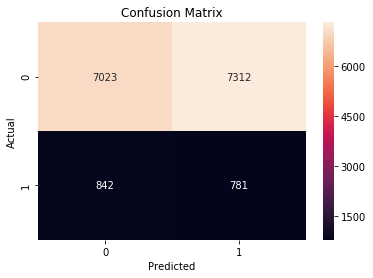

In [16]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(target, preds):
    cm = confusion_matrix(target, preds)
    #cm_display = ConfusionMatrixDisplay(cm).plot()
    ax = sns.heatmap(cm, annot=True, fmt='g');
    ## Modify the Axes Object directly to set various attributes such as the
    ## Title, X/Y Labels.
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');
    plt.show()
    
create_confusion_matrix(target_test, preds_dummy)

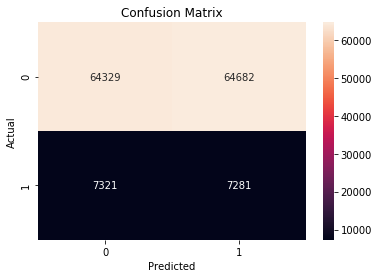

In [17]:
create_confusion_matrix(target_train, dummy.predict(features_train))

In [18]:
target_test.value_counts()

0    14335
1     1623
Name: toxic, dtype: int64

### Логистическая регрессия

In [19]:
log_reg = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')

C_values = {'C': np.logspace(0, 3, 10)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])},
             scoring='f1')

In [20]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 4.641588833612778}
0.7597252767232499


In [21]:
lr = LogisticRegression(random_state=12345, class_weight='balanced').fit(features_train, target_train)
preds_lr_train = lr.predict(features_train)
preds_lr_test = lr.predict(features_test)
print('F1 на обучающей выборке: {:.2f}'.format(f1_score(target_train, preds_lr_train)))
print('Кросс_валидация: ', cross_val_score(lr, features_train, target_train, cv=5))
print('F1 на тестовой выборке: {:.2f}'.format(f1_score(target_test, preds_lr_test)))

F1 на обучающей выборке: 0.82
Кросс_валидация:  [0.94043101 0.94147547 0.94234586 0.94293573 0.94230903]
F1 на тестовой выборке: 0.76


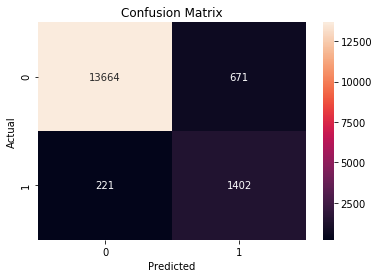

In [22]:
create_confusion_matrix(target_test, preds_lr_test)

F1 на тестовой 0.76. Получили быстро и легко. Посмотрим, что дадут более сложные и долгие модели.

###  Дерево решений

In [23]:
dtc = DecisionTreeClassifier(random_state=12345, class_weight='balanced')

parameters = {
    'max_depth' : range(16, 40, 2)
}

def find_best_model(X_train, y_train, model, parameters):
#    fit_params={"early_stopping_rounds": 5}
    grid = RandomizedSearchCV(model, parameters, scoring=f1_scorer, cv=3, n_iter=3, verbose=2)
    grid.fit(X_train, y_train)

    print('Лучшие параметры:', grid.best_params_)
    print('F1_dtc = {:.2f}'.format(grid.best_score_))
    return grid, grid.best_score_

In [24]:
grid_dtc, f1_dtc_train = find_best_model(features_train, target_train, dtc, parameters)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .......................................max_depth=32; total time=  41.6s
[CV] END .......................................max_depth=32; total time=  41.8s
[CV] END .......................................max_depth=32; total time=  43.0s
[CV] END .......................................max_depth=34; total time=  43.7s
[CV] END .......................................max_depth=34; total time=  46.2s
[CV] END .......................................max_depth=34; total time=  46.6s
[CV] END .......................................max_depth=16; total time=  23.2s
[CV] END .......................................max_depth=16; total time=  25.9s
[CV] END .......................................max_depth=16; total time=  21.4s
Лучшие параметры: {'max_depth': 34}
F1_dtc = 0.65


Посмотрим результат работы моделей на тестовой выборке:

In [25]:
def get_predictions_and_f1(model, features, target):
    
    preds = model.predict(features)
    f1 = f1_score(target, preds)
    print('F1 = {:.2f}'.format(f1))
    
    return f1, preds

In [26]:
f1_dtc_test, preds_dtc = get_predictions_and_f1(grid_dtc, features_test, target_test)

F1 = 0.64


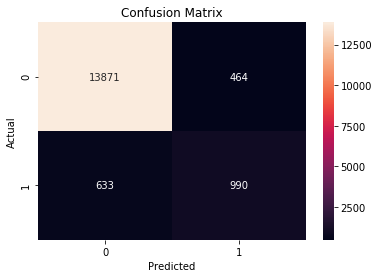

In [27]:
create_confusion_matrix(target_test, preds_dtc)

### Случайный лес

In [28]:
rfc = RandomForestClassifier(random_state=12345, class_weight='balanced')

parameters = {
    'n_estimators' : range(100, 140, 10),
    'max_depth' : range(15, 21, 1)
}

In [29]:
grid_rfc, f1_rfc_train = find_best_model(features_train, target_train, rfc, parameters)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .....................max_depth=17, n_estimators=110; total time=  46.1s
[CV] END .....................max_depth=17, n_estimators=110; total time=  47.3s
[CV] END .....................max_depth=17, n_estimators=110; total time=  45.6s
[CV] END .....................max_depth=19, n_estimators=120; total time=  57.7s
[CV] END .....................max_depth=19, n_estimators=120; total time=  57.3s
[CV] END .....................max_depth=19, n_estimators=120; total time=  57.3s
[CV] END .....................max_depth=16, n_estimators=110; total time=  43.4s
[CV] END .....................max_depth=16, n_estimators=110; total time=  45.2s
[CV] END .....................max_depth=16, n_estimators=110; total time=  49.3s
Лучшие параметры: {'n_estimators': 120, 'max_depth': 19}
F1_dtc = 0.39


Посмотрим результат работы моделей на тестовой выборке:

In [30]:
f1_rfc_test, preds_rfc = get_predictions_and_f1(grid_rfc, features_test, target_test)

F1 = 0.39


### LightGBM

In [31]:
lgbm = LGBMClassifier(random_state=12345, class_weight='balanced')

parameters = {
    'n_estimators': range(100, 250, 10),
    'max_depth' : range(10, 60, 3)
}
#    'num_leaves': range(20,30,10),
#    'max_depth' : range(18, 40, 2)
#    'n_estimators': range(100, 200, 10), 

#'LGBMClassifier': {'learning_rate': 0.1,
#  'max_depth': 16,
#  'min_child_samples': 4}

In [32]:
grid_lgbm, f1_lgbm_train = find_best_model(features_train, target_train, lgbm, parameters)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .....................max_depth=10, n_estimators=100; total time= 1.6min
[CV] END .....................max_depth=10, n_estimators=100; total time= 4.8min
[CV] END .....................max_depth=10, n_estimators=100; total time= 5.3min
[CV] END .....................max_depth=16, n_estimators=190; total time= 5.5min
[CV] END .....................max_depth=16, n_estimators=190; total time= 5.3min
[CV] END .....................max_depth=16, n_estimators=190; total time= 4.2min
[CV] END .....................max_depth=28, n_estimators=130; total time= 5.3min
[CV] END .....................max_depth=28, n_estimators=130; total time= 3.8min
[CV] END .....................max_depth=28, n_estimators=130; total time= 4.0min
Лучшие параметры: {'n_estimators': 190, 'max_depth': 16}
F1_dtc = 0.75


Здесь было посчитано при последних параметрах RandomizedSearchCV. Но упало пока грузило( не успеваю пересчитать, и не уверена, что будет возможность воспользоваться компом до дедлайна( так что отправлю, как есть. LGBM на тестовой выборке показал F1=0.75

In [33]:
lgbm = LGBMClassifier(random_state=12345, class_weight='balanced',n_estimators=220, max_depth=22)
lgbm.fit(features_train, target_train)

LGBMClassifier(class_weight='balanced', max_depth=22, n_estimators=220,
               random_state=12345)

Посмотрим результат работы моделей на тестовой выборке:

In [34]:
f1_lgbm_test, preds_lgbm = get_predictions_and_f1(grid_lgbm, features_test, target_test)

F1 = 0.75


## Выводы

- Предварительный анализ показал сильную несбалансированность классов. Это учитывалось при обучении моделей.


- Сделали лемматизацию каждого текста и очистку от мусора.


- Оценку важности слова определили величиной TF-IDF.


- Обучили несколько моделей. Лучший результат показала модель логистической регрессии с F1 = 0.76


- Есть предположение, что более тщательный подбор параметров улучшит результаты более сложных моделей.